# Import libraries

Import required libraries and initialize Stockfish engine

TODO: re-write engines to use chess.engine instead, so we can use lc0 with Maia weights as well

In [ ]:
import chess
import chess.engine
import chess.pgn
import os
import math

In [ ]:
stockfish = chess.engine.SimpleEngine.popen_uci(os.path.join('bin', 'stockfish_14_x64'))
maia = chess.engine.SimpleEngine.popen_uci(os.path.join(os.path.expanduser('~'), 'repos', 'lc0', 'build', 'release', 'lc0'))

# Load pgns

In [ ]:
LIMIT = 50 # max number of games to load

In [30]:
pgn = open(os.path.join('data', 'lichess_db_standard_rated_2013-01.pgn'))
games = []
for _ in range(LIMIT):
    game = chess.pgn.read_game(pgn)
    games.append(game)
print(len(games))

50


# Define pipeline functions

* Calculate value of a piece
* Get Stockfish evaluations of tactic move suggestions
* Get top-n Stockfish move suggestions for a given board position
* Evaluate the move suggestions from a tactic against Stockfish suggestions using DCG (discounted
  cumulative gain)


In [ ]:
def value(piece_type):
    king_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 99
    }
    return king_values[piece_type]

In [ ]:
ray_piece_types = [chess.QUEEN, chess.ROOK, chess.BISHOP]

def is_defended(board, piece, square) -> bool:
    if board.attackers(piece.color, square):
        return True
    # ray defense https://lichess.org/editor/6k1/3q1pbp/2b1p1p1/1BPp4/rp1PnP2/4PRNP/4Q1P1/4B1K1_w_-_-_0_1
    for attacker in board.attackers(not piece.color, square):
        attacker_piece = board.piece_at(attacker)
        assert(attacker_piece)
        if attacker_piece.piece_type in ray_piece_types:
            bc = board.copy(stack = False)
            bc.remove_piece_at(attacker)
            if bc.attackers(piece.color, square):
                return True

    return False

def is_hanging(board, piece, square) -> bool:
    return not is_defended(board, piece, square)


In [ ]:
def behind(a, b):
    whole_ray = chess.SquareSet.ray(a, b)
    b_first = False
    for square in whole_ray:
        if square == b:
            b_first = True
            break
        if square == a:
            b_first = False
            break
    if b_first:
        for square in reversed(list(whole_ray)):
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = reversed(list(whole_ray))
    else:
        for square in whole_ray:
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = whole_ray
    return list(partial_ray)

In [ ]:
def get_evals(engine, board, suggestions):
    evals = []
    analysis = engine.analyse(board, limit=chess.engine.Limit(time=1), multipv=len(suggestions), root_moves=suggestions)
    # print(analysis)
    evals = [(root['score'].relative, root['pv'][0]) for root in analysis]
    return evals

In [21]:
def get_top_n_moves(engine, n, board):
    analysis = engine.analyse(board, limit=chess.engine.Limit(time=1), multipv=n)
    # print(analysis)
    top_n_moves = [(root['score'].relative, root['pv'][0]) for root in analysis]
    return top_n_moves

In [ ]:
def evaluate(evaluated_suggestions, top_moves):
    dcg = 0
    for idx, (evaluated_move, top_move) in enumerate(zip(evaluated_suggestions, top_moves)):
        # print(evaluated_move, top_move)
        score, move = evaluated_move
        eval = score.score(mate_score=2000)
        score_top, move_top = top_move
        top_eval = score_top.score(mate_score=2000)
        dcg += abs(top_eval - eval) / math.log2(1 + (idx + 1))
    return dcg

# Define tactic heuristics

## Fork

### Pattern

if a non-king piece can move to a square where it attacks more than 1 piece of greater value than a pawn

### Suggestion

suggest the moves where the condition holds

In [ ]:
def fork(board):
    match = False
    suggestions = []
    for move in board.legal_moves:
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type == chess.KING:
            continue
        board.push(move)
        board.push(chess.Move.null())
        nb = 0
        # print(move, chess.square_name(move.to_square), board.attacks(move.to_square))
        for attacks in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacks)
            # print(chess.square_name(attacks), attacked_piece, value(attacked_piece))
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            # if attacked_piece.piece_type == chess.PAWN:
            #    continue
            if value(attacked_piece.piece_type) > value(moved_piece_type) or (
                is_hanging(board, attacked_piece, attacks) and
                attacks not in board.attackers(not board.turn, move.to_square)
            ):
                nb += 1
        board.pop()
        board.pop()
        if nb > 1:
            match = True
            suggestions.append(move)
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

## Skewer

### Pattern

if a sliding piece can be moved to a square where it attacks a piece of higher value and
simultaneously x-rays an unsupported piece of lower value

### Suggestion

suggest moves where the condition holds


In [ ]:
def skewer(board):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type not in ray_piece_types:
            continue
        board.push(move)
        board.push(chess.Move.null())
        if not board.is_valid():
            board.pop()
            board.pop()
            continue
        for attacked_square in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacked_square)
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            # if piece immediately "behind" attacked piece is of opponent color and of lower value
            # than attacked piece, then match
            partial_ray = behind(move.to_square, attacked_square)
            # print(partial_ray)
            for square in partial_ray:
                if (xrayed_piece := board.piece_at(square)) is not None:
                    if (
                        xrayed_piece.color != board.turn and # opponent color
                        is_hanging(board, xrayed_piece, square) and # unsupported
                        value(xrayed_piece.piece_type) < value(attacked_piece.piece_type) # lesser value
                    ):
                        match = True
                        suggestions.append(move)
                    break
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

## Absolute Pin

### Pattern

If a move leads to an absolute pin

### Suggestion

The move which leads to an absolute pin

In [ ]:
def absolute_pin(board):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        board.push(move)
        board.push(chess.Move.null())
        if not board.is_valid():
            board.pop()
            board.pop()
            continue
        for attacked_square in board.attacks(move.to_square):
            if board.is_pinned(not board.turn, attacked_square):
                match = True
                suggestions.append(move)
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

## Pin

### Pattern

If a move leads to an attack on a piece of equal or lower value, behind which is a piece of higher
value than the attacking piece

### Suggestion

The move which leads to the above situation

In [ ]:
def pin(board):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type not in ray_piece_types:
            continue
        board.push(move)
        board.push(chess.Move.null())
        if not board.is_valid():
            board.pop()
            board.pop()
            continue
        for attacked_square in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacked_square)
            if (
                attacked_piece is None or # a piece is attacked
                attacked_piece.color == board.turn or # attacked piece belongs to opponent
                value(moved_piece_type) > value(attacked_piece.piece_type) # attacked piece is of lesser/equal value than attacker
            ):
                continue
            # if piece immediately "behind" attacked piece is of opponent color and of higher value
            # than attacked piece, then match
            partial_ray = behind(move.to_square, attacked_square)
            # print(partial_ray)
            for square in partial_ray:
                if (xrayed_piece := board.piece_at(square)) is not None:
                    if (
                        xrayed_piece.color != board.turn and # opponent color
                        value(xrayed_piece.piece_type) > value(attacked_piece.piece_type) # greater value
                    ):
                        match = True
                        suggestions.append(move)
                    break
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

## Discovered Check

### Pattern

If a piece can be moved to a square such that another piece now delivers check

### Suggestion

The move which leads to the above situation

In [ ]:
def discovered_check(board):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        board.push(move)
        if not board.is_valid() or not board.is_check():
            board.pop()
            continue
        if move.to_square in board.checkers():
            board.pop()
            continue
        else:
            match = True
            suggestions.append(move)
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

# Calculate metrics for all games

In [23]:
total = 0  # total number of games
matches = 0 # number of matches found in a position across all games
total_dcg = 0
engine = maia
for game in games:
    board = game.board()
    total += 1
    for move in game.mainline_moves():
        board.push(move)
        match, suggestions = discovered_check(board)
        if match:
            matches += 1
            evals = get_evals(engine, board, suggestions)
            top_n_moves = get_top_n_moves(engine, len(suggestions), board)
            # print(board.fen(), evaluated_suggestions, top_n_moves)
            total_dcg += evaluate(evals, top_n_moves)
            
print(f'Coverage = {matches / total}') # average number of matches per game
print(f'Total DCG = {total_dcg}')

Coverage = 0.4
Total DCG = 6407.01324529646


# Individual Test Position

A single constructed position for testing the constructed heuristics

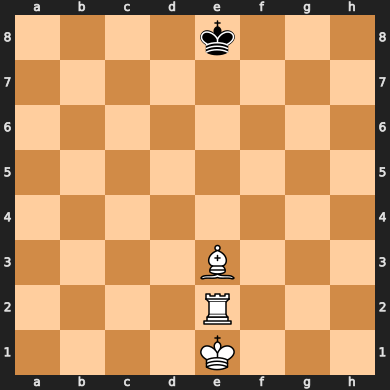

In [27]:
board = chess.Board('4k3/8/8/8/8/4B3/4R3/4K3 w - - 0 1')
board

In [28]:
engine = maia
# print(engine.options)

In [29]:
match, suggestions = discovered_check(board)
print(suggestions)
analysis = engine.analyse(board, chess.engine.Limit(nodes=1), multipv=len(suggestions), root_moves=suggestions)
print(analysis)

[Move.from_uci('e3d4'), Move.from_uci('e3c5'), Move.from_uci('e3g1')]
[{'depth': 6, 'seldepth': 14, 'time': 0.038, 'nodes': 1203, 'score': PovScore(Cp(+110), WHITE), 'tbhits': 0, 'multipv': 1, 'pv': [Move.from_uci('e3c5'), Move.from_uci('e8d7'), Move.from_uci('e2d2'), Move.from_uci('d7c6'), Move.from_uci('c5a3'), Move.from_uci('c6b5'), Move.from_uci('d2c2'), Move.from_uci('b5a4'), Move.from_uci('c2c3'), Move.from_uci('a4b5'), Move.from_uci('e1d2')]}, {'depth': 6, 'seldepth': 14, 'time': 0.038, 'nodes': 1203, 'score': PovScore(Cp(+109), WHITE), 'tbhits': 0, 'multipv': 2, 'pv': [Move.from_uci('e3d4'), Move.from_uci('e8d7'), Move.from_uci('e1d2'), Move.from_uci('d7d6'), Move.from_uci('d2d3'), Move.from_uci('d6d5'), Move.from_uci('e2e5')]}, {'depth': 6, 'seldepth': 14, 'time': 0.038, 'nodes': 1203, 'score': PovScore(Cp(+129), WHITE), 'tbhits': 0, 'multipv': 3, 'pv': [Move.from_uci('e3g1'), Move.from_uci('e8d7'), Move.from_uci('e2d2'), Move.from_uci('d7e6'), Move.from_uci('d2e2'), Move.from

In [22]:
match, suggestions = discovered_check(board)
# print(match, suggestions)
top_moves = get_top_n_moves(engine, len(suggestions), board)
# print(top_moves)
if match:
    evals = get_evals(stockfish, board, suggestions)
    # print(board.fen(), match, list(zip(suggestions, evals)), top_moves)
print(evaluate(evals, top_moves))

4244.481903614339


In [ ]:
engine.quit()